In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from PIL import Image

import itertools
import time
import pickle

from BPGenerator import *

import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib.pyplot import imshow
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
#K.clear_session()

from sklearn.cluster import KMeans

In [2]:
# initialize the Bongard Problem generator to produce tiles of size 100x100
BPG = BPGenerator((100, 100))

In [3]:
# create training and testing data

BP_num = 61 # focus on BP#61

nb_train = 50000
nb_test = 10000
resizing = 96

X_train = []
y_train = []

for i in range(nb_train):
    side = "left" if i%2==0 else "right"

    # generate a random tile for this problem, resize it down to 20x20, and convert to vector
    x = BPG.flatten_img(BPG.draw_tile(BP_num, side).resize((resizing, resizing), Image.LANCZOS))
    label = 0 if side == "left" else 1

    X_train.append(x)
    y_train.append(label)

X_test = []
y_test = []

for i in range(nb_test):
    side = "left" if i%2==0 else "right"

    # generate a random tile for this problem, resize it down to 20x20, and convert to vector
    x = BPG.flatten_img(BPG.draw_tile(BP_num, side).resize((resizing, resizing), Image.LANCZOS))
    label = 0 if side == "left" else 1

    X_test.append(x)
    y_test.append(label)

In [4]:
x_train = np.asarray(X_train).astype('float32')
x_test = np.asarray(X_test).astype('float32')
x_train = np.reshape(x_train, (len(x_train), 96, 96, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 96, 96, 1))  # adapt this if using `channels_first` image data format

In [5]:
x_train.shape

(50000, 96, 96, 1)

In [6]:
x_test.shape

(10000, 96, 96, 1)

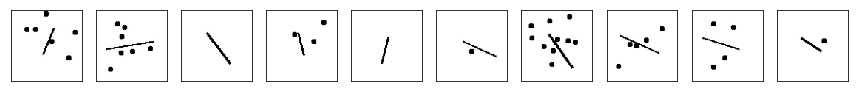

In [7]:
#部分显示图片
n = 10 # how many digits we will display
plt.figure(figsize=(15, 15))
for i in range(n):
    # display original
    #ax = plt.subplot(2, n, i + 1)
    ax=plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i].reshape(96,96))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [12]:
np.save('BP61_x_train.npy', x_train)
np.save('BP61_x_test.npy', x_test)

In [8]:
# 搭建 autoencoder 模型

input_shape = (96, 96, 1)
model = Sequential()

# encoder 部分: ( conv + relu + maxpooling ) * 3
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# decoder 部分: ( conv + relu + upsampling ) * 3 与 encoder 过程相反
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))

model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 8)         584       
__________

In [9]:
from keras.callbacks import TensorBoard

model.fit(x_train, x_train,
          epochs=50,
          batch_size=128,
          shuffle=True,
          validation_data=(x_test, x_test),
          callbacks=[TensorBoard(log_dir='/notebooks/yuanyuan/Test/autoencoder')])

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 318us/step - loss: 0.0949 - acc: 0.9272 - val_loss: 0.0488 - val_acc: 0.9330
Epoch 2/50
50000/50000 [==============================] - 15s 298us/step - loss: 0.0441 - acc: 0.9341 - val_loss: 0.0448 - val_acc: 0.9333
Epoch 3/50
50000/50000 [==============================] - 15s 306us/step - loss: 0.0375 - acc: 0.9361 - val_loss: 0.0355 - val_acc: 0.9368
Epoch 4/50
50000/50000 [==============================] - 15s 301us/step - loss: 0.0343 - acc: 0.9371 - val_loss: 0.0338 - val_acc: 0.9369
Epoch 5/50
50000/50000 [==============================] - 15s 310us/step - loss: 0.0324 - acc: 0.9376 - val_loss: 0.0323 - val_acc: 0.9377
Epoch 6/50
50000/50000 [==============================] - 15s 306us/step - loss: 0.0311 - acc: 0.9380 - val_loss: 0.0315 - val_acc: 0.9377
Epoch 7/50
50000/50000 [==============================] - 15s 306us/step - loss: 0.0301 - acc: 0.9382 - val_loss: 0.

In [10]:
model.save('BP61-autoencoder-model.h5')

Before autoencoding:


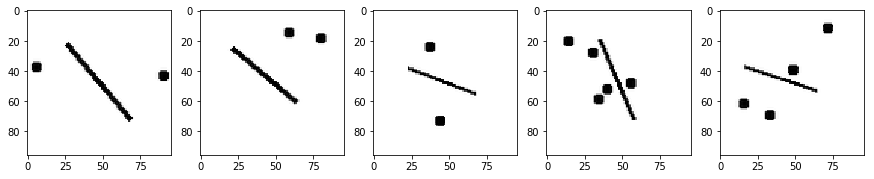

After decoding:


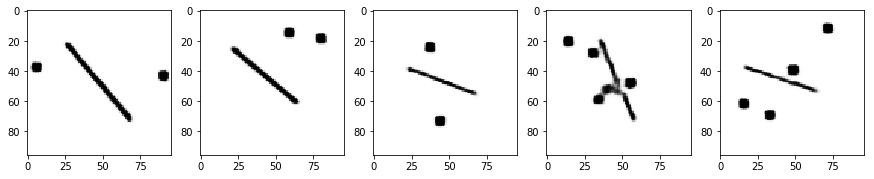

In [13]:
# 检查 autoencoder 的效果
def plot_some(im_list):
    plt.figure(figsize=(15,4))
    for i, array in enumerate(im_list):
        plt.subplot(1, len(im_list), i+1)
        plt.imshow(array.reshape(96,96))
        #plt.axis('off')
    plt.show()

img_decoded = model.predict(x_test[:5])

print('Before autoencoding:')
plot_some(x_test[:5])
print('After decoding:')
plot_some(img_decoded)

In [14]:
# 取 100 个样本来做下分析
X_sample = x_train[:100]
print(X_sample.shape)

(100, 96, 96, 1)


In [15]:
# 创建一个获取图片 encoded 结果的函数, 即取模型的 encoder 部分 (前六层)
# Keras 如何获取中间层, 参考官方文档:
# https://keras.io/zh/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
get_encoded = K.function([model.layers[0].input], [model.layers[5].output])

# 获取样本的 encoded 结果
encoded_sample = get_encoded([X_sample])[0]

print(encoded_sample.shape)

(100, 12, 12, 8)


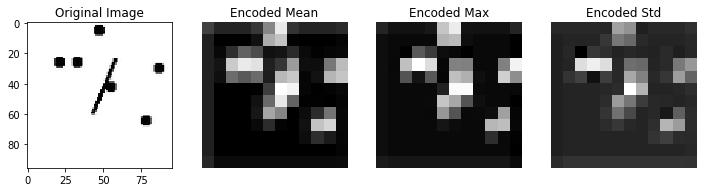

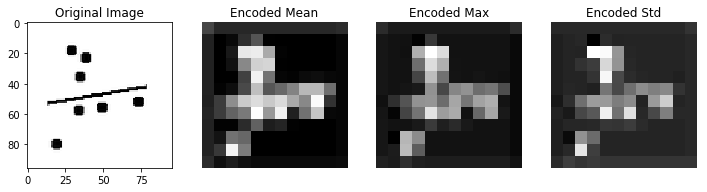

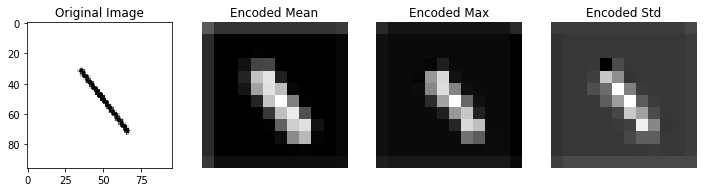

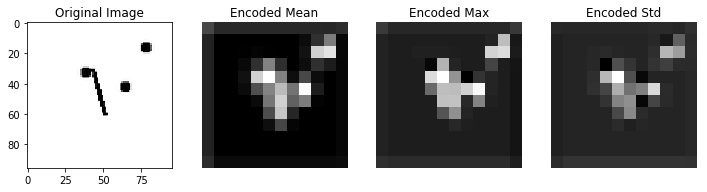

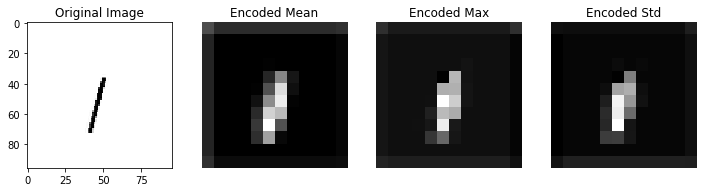

In [45]:
# 看下 encode 之后的图片是什么情况
# 因为 shape 是 16*16*8, 因此需要转成灰度才能将图片显示出来, 分别将最后的维度用 mean, max, std 来取值

for n_image in range(0, 5):
    
    plt.figure(figsize=(12,4))

    plt.subplot(1,4,1)
    plt.imshow(X_sample[n_image].reshape(96,96))
    #plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(encoded_sample[n_image].mean(axis=-1))
    plt.axis('off')
    plt.title('Encoded Mean')

    plt.subplot(1,4,3)
    plt.imshow(encoded_sample[n_image].max(axis=-1))
    plt.axis('off')
    plt.title('Encoded Max')

    plt.subplot(1,4,4)
    plt.imshow(encoded_sample[n_image].std(axis=-1))
    plt.axis('off')
    plt.title('Encoded Std')

    plt.show()

In [54]:
# 所有训练图片 encoded 之后的数据

X_train_encoded = np.empty((len(x_train), 12, 12, 8), dtype='float32')

step = 100
for i in range(0, len(x_train), step):
    x_batch = get_encoded([x_train[i:i+step]])[0]
    X_train_encoded[i:i+step] = x_batch

print(X_train_encoded.shape)

(50000, 12, 12, 8)


In [55]:
X_train_encoded[0].shape

(12, 12, 8)

In [56]:
# 所有测试图片 encoded 之后的数据

X_test_encoded = np.empty((len(x_test), 12, 12, 8), dtype='float32')

step = 100
for i in range(0, len(x_test), step):
    x_batch = get_encoded([x_test[i:i+step]])[0]
    X_test_encoded[i:i+step] = x_batch

print(X_test_encoded.shape)

(10000, 12, 12, 8)


In [57]:
# reshape, 其实相当于 flatten, 之后给 KMeans 用

X_train_encoded_reshape = X_train_encoded.reshape(X_train_encoded.shape[0], X_train_encoded.shape[1]*X_train_encoded.shape[2]*X_train_encoded.shape[3])
print(X_train_encoded_reshape.shape)
X_test_encoded_reshape = X_test_encoded.reshape(X_test_encoded.shape[0], X_test_encoded.shape[1]*X_test_encoded.shape[2]*X_test_encoded.shape[3])
print(X_test_encoded_reshape.shape)


(50000, 1152)
(10000, 1152)


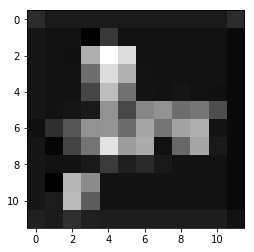

In [58]:
plt.imshow(X_train_encoded[1].max(axis=-1))

In [ ]:
# autoencoder 各层输出

get_1st_layer  = K.function([model.layers[0].input], [model.layers[0].output])
get_2nd_layer  = K.function([model.layers[0].input], [model.layers[1].output])
get_3rd_layer  = K.function([model.layers[0].input], [model.layers[2].output])
get_4th_layer  = K.function([model.layers[0].input], [model.layers[3].output])
get_5th_layer  = K.function([model.layers[0].input], [model.layers[4].output])
get_6th_layer  = K.function([model.layers[0].input], [model.layers[5].output])
get_7th_layer  = K.function([model.layers[0].input], [model.layers[6].output])
get_8th_layer  = K.function([model.layers[0].input], [model.layers[7].output])
get_9th_layer  = K.function([model.layers[0].input], [model.layers[8].output])
get_10th_layer = K.function([model.layers[0].input], [model.layers[9].output])
get_11th_layer = K.function([model.layers[0].input], [model.layers[10].output])

sample_layer_1  = get_1st_layer([X_train])[0]
sample_layer_2  = get_2nd_layer([X_train])[0]
sample_layer_3  = get_3rd_layer([X_train])[0]
sample_layer_4  = get_4th_layer([X_train])[0]
sample_layer_5  = get_5th_layer([X_train])[0]
sample_layer_6  = get_6th_layer([X_train])[0]
sample_layer_7  = get_7th_layer([X_train])[0]
sample_layer_8  = get_8th_layer([X_train])[0]
sample_layer_9  = get_9th_layer([X_train])[0]
sample_layer_10 = get_10th_layer([X_train])[0]
sample_layer_11 = get_11th_layer([X_train])[0]
img_decoded = model.predict(X_train[0:10])

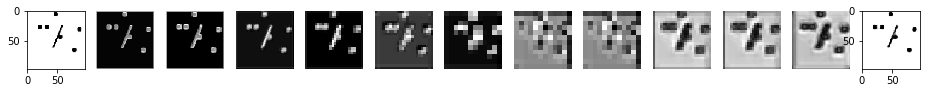

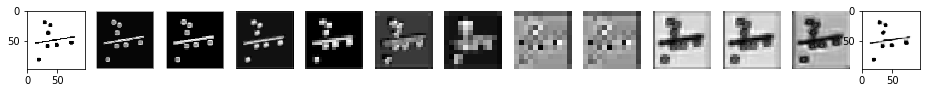

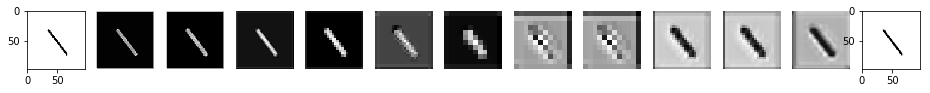

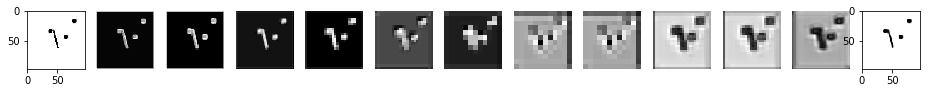

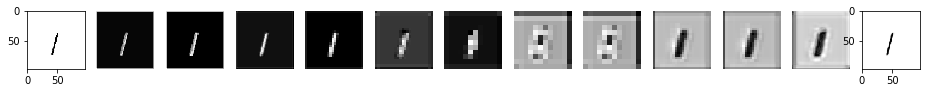

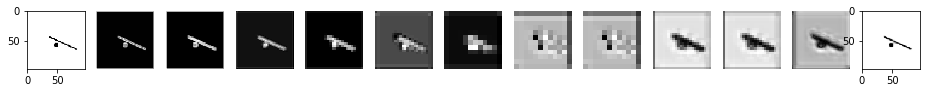

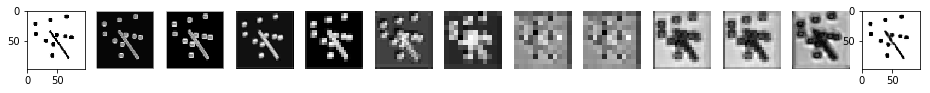

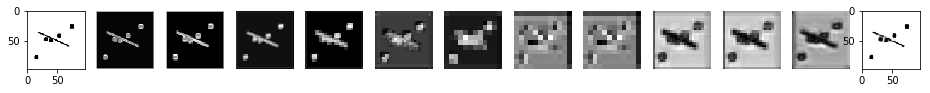

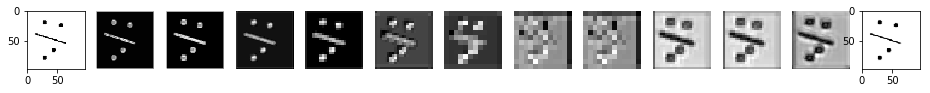

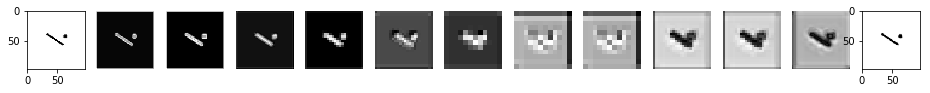

In [22]:
# 打印出中间层图片

for n_image in range(0, 10):
    
    plt.figure(figsize=(16,8))

    plt.subplot(1,13,1)
    plt.imshow(X_sample[n_image].max(axis=-1))
    #plt.axis('off')

    plt.subplot(1,13,2)
    plt.imshow(sample_layer_1[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,3)
    plt.imshow(sample_layer_2[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,4)
    plt.imshow(sample_layer_3[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,5)
    plt.imshow(sample_layer_4[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,6)
    plt.imshow(sample_layer_5[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,7)
    plt.imshow(sample_layer_6[n_image].max(axis=-1))
    plt.axis('off')

    plt.subplot(1,13,8)
    plt.imshow(sample_layer_7[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,9)
    plt.imshow(sample_layer_8[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,10)
    plt.imshow(sample_layer_9[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,11)
    plt.imshow(sample_layer_10[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,12)
    plt.imshow(sample_layer_11[n_image].max(axis=-1))
    plt.axis('off')
    
    plt.subplot(1,13,13)
    plt.imshow(img_decoded[n_image].max(axis=-1))
    #plt.axis('off')
    
    plt.show()

In [60]:
decoded_train= X_train_encoded_reshape
decoded_test= X_test_encoded_reshape

In [61]:
classify_model = GradientBoostingClassifier(learning_rate=0.3, n_estimators=8)
classify_model.fit(decoded_train, y_train)
y_pred = classify_model.predict(decoded_test)
print(y_pred)

[0 0 0 ... 0 0 1]


In [62]:
decoded_train

array([[0.38665342, 0.75536245, 1.7550061 , ..., 0.        , 0.        ,
        0.9576836 ],
       [0.38665342, 0.75536245, 1.7550061 , ..., 0.        , 0.        ,
        0.9576836 ],
       [0.38665342, 0.75536245, 1.7550061 , ..., 0.        , 0.        ,
        0.9576836 ],
       ...,
       [0.38665342, 0.75536245, 1.7550061 , ..., 0.        , 0.        ,
        0.9576836 ],
       [0.38665342, 0.75536245, 1.7550061 , ..., 0.        , 0.        ,
        0.9576836 ],
       [0.38665342, 0.75536245, 1.7550061 , ..., 0.        , 0.        ,
        0.9576836 ]], dtype=float32)

In [ ]:
print("Resizing\tlr\tn_estimators\taccuracy")
for lr, n_estimators in itertools.product([1., 0.3, 0.1, 0.03, 0.01], [1, 2, 4, 8, 16, 32, 64, 128]):
    classify_model = GradientBoostingClassifier(learning_rate=lr, n_estimators=n_estimators)
    classify_model.fit(decoded_train, y_train)
    
    y_pred = classify_model.predict(decoded_test)

    accuracy = np.average(np.array(y_test) == np.array(y_pred))

    print("{}\t{}\t{}\t{:.3f}".format(resizing, lr, n_estimators, accuracy))

In [76]:
# KMeans 聚类
n_clusters = 2
km = KMeans(n_clusters=n_clusters)
km.fit(decoded_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

<BarContainer object of 2 artists>

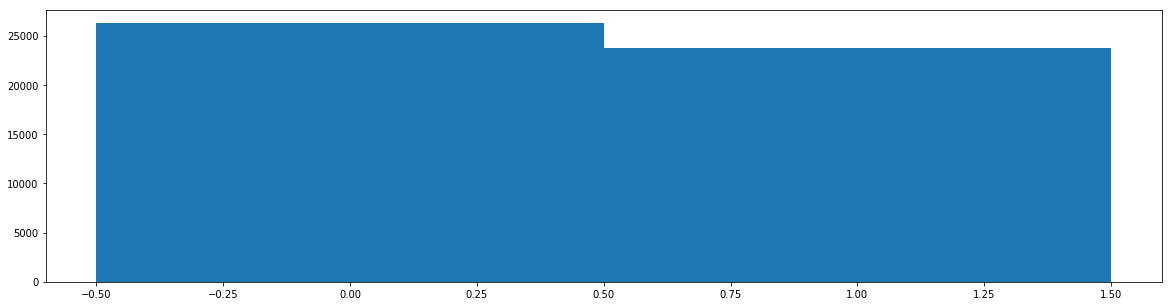

In [77]:
# 看下 clusters 的分布结果

plt.figure(figsize=(20,5))
cluster_elements = [(km.labels_==i).sum() for i in range(n_clusters)]
plt.bar(range(n_clusters), cluster_elements, width=1)

In [78]:
#每个聚类的 encoded 均值

average_clusters_encoded = []
for i in range(n_clusters):
    average_clusters_encoded.append(X_train_encoded[km.labels_==i].mean(axis=0))

average_clusters_encoded = np.asarray(average_clusters_encoded)

print(average_clusters_encoded.shape)

(2, 12, 12, 8)


In [79]:
#取出模型的 decoder 部分

get_decoded = K.function([model.layers[6].input],
                         [model.layers[-1].output])

# "平均" decoded 图像
decoded_clusters = get_decoded([average_clusters_encoded])

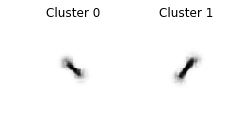

In [80]:
# 打印出所有聚类的" 平均" decoded 图像

plt.figure(figsize=(20,20))

for i in range(n_clusters):
    plt.subplot(10, 10, i+1)
    plt.imshow(decoded_clusters[0][i].reshape(96,96))
    plt.title('Cluster {}'.format(i))
    plt.axis('off')

plt.show()

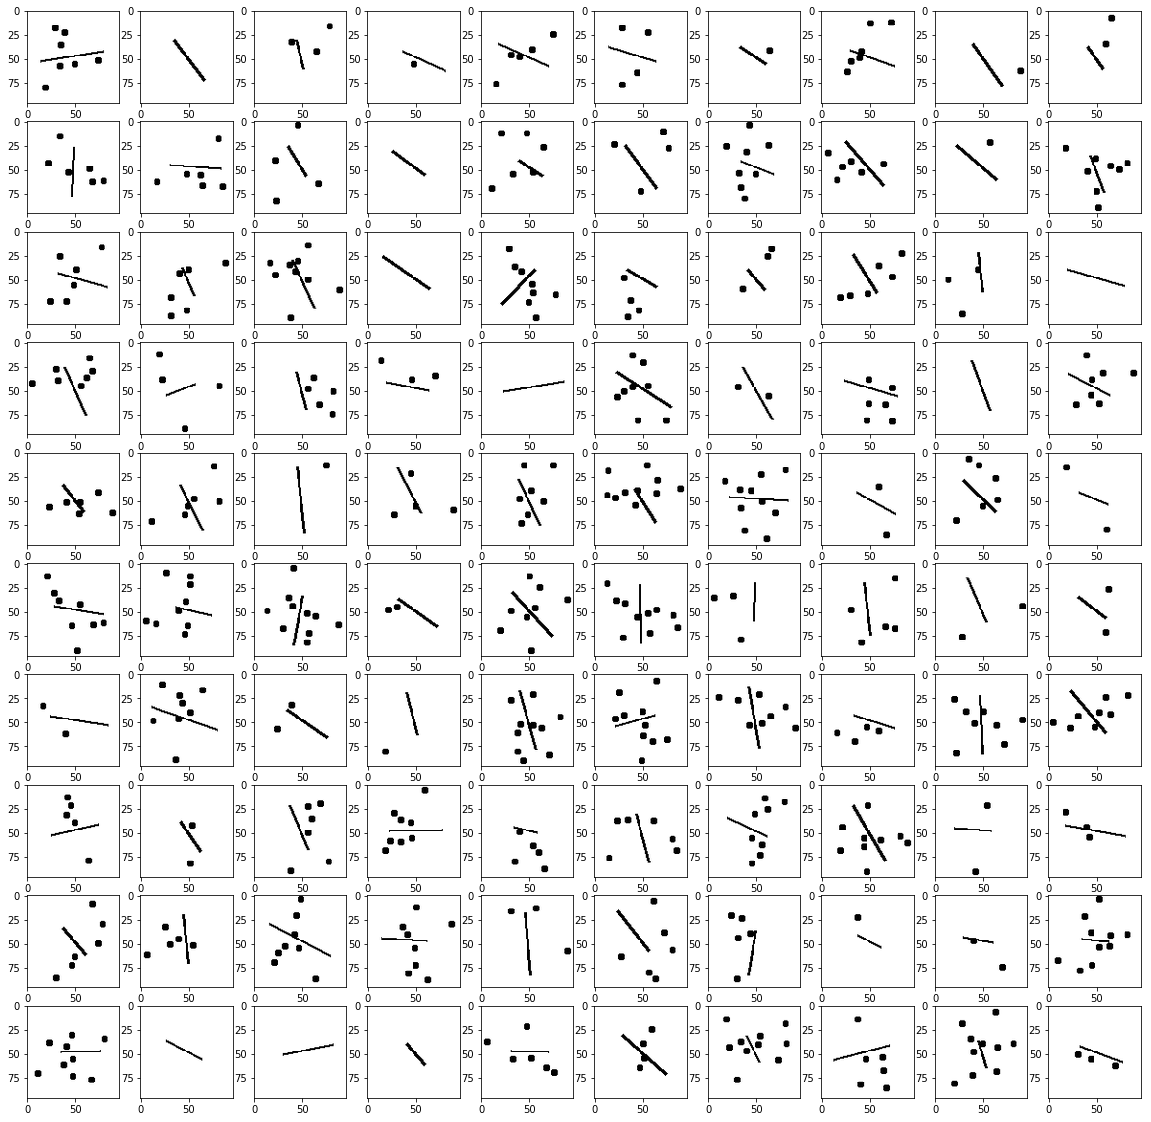

In [82]:
# 从上面可以看到有比较明显的聚类效果

plt.figure(figsize=(20, 20))

cluster =0
rows, cols = 10, 10
start = 0

labels = np.where(km.labels_==cluster)[0][start:start+rows*cols]
for i, label in enumerate(labels):
    plt.subplot(rows, cols, i+1)
    plt.imshow(x_train[label].reshape(96,96))
    #plt.axis('off')